### Importing all relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import itertools
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import warnings
warnings.simplefilter('ignore')
import plotly.express as px

import xlsxwriter

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller

import sqlite3
import sqlalchemy

## Create a database for storing values and results of regression analysis.
#conn = sqlite3.connect('10000_reg.db')
#c = conn.cursor()
engine = sqlalchemy.create_engine('sqlite:///10000_reg.db')

Previous to importing data, the group downloaded data via the eikon API as well as the web.datareader from FRED. The code can be found in the file: AQM - Initial data download

# Importing data - United States

## Stocks
##### Is a selection of 16 stocks randomly selected from NASDAQ

In [2]:
stocks = pd.read_csv("Stock_data.csv")
stocks["Date"] = pd.to_datetime(stocks["Date"])
stocks = stocks.set_index("Date")
stocks.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Date,,,,,,,,,,,,,,,,
2013-01-31,16.267484,193.965154,30.981,3.0650,73.92,66.92,39.4775,11.32,25.860049,92.779909,37.24,69.95,95.29,27.025,101.45,54.82
2013-02-28,15.764270,191.825586,27.250,3.1650,76.11,68.50,39.6600,11.23,25.945364,91.827994,38.72,70.78,95.90,27.230,105.43,48.06
2013-03-31,15.809270,203.736481,25.580,3.2075,81.53,69.78,42.4600,12.18,27.357808,96.197734,40.44,74.83,99.69,29.505,98.20,53.32
2013-04-30,15.813556,193.458917,27.769,3.4425,85.23,73.35,42.1150,12.31,27.556877,98.301011,42.33,77.72,102.14,31.800,94.01,60.85
2013-05-31,16.061948,198.693215,24.348,3.6175,84.18,78.66,44.5350,13.66,25.812651,99.389820,39.99,74.84,96.57,30.830,96.34,66.44


## Macro variables
##### Is a selection of 10 macro variables from FRED

In [3]:
#Changed the date format in Excel to match that of the stock data
macro = pd.read_csv("Macro_data.csv")
macro["Date"] = pd.to_datetime(macro["Date"])
macro.set_index("Date", inplace=True)
macro.head()

,CPIAUCSL,WTISPLC,T5YIFRM,MRTSSM44X72USS,INDPRO,SPCS20RSA,UNRATE,M2SL,PPIACO,FEDFUNDS
Date,,,,,,,,,,
2013-01-31,232.937,95.32,2.86,417159.0,98.6458,149.565720,7.7,10479.1,204.3,0.15
2013-02-28,232.282,93.05,2.85,414092.0,99.0597,150.963775,7.5,10547.2,204.0,0.14
2013-03-31,231.797,92.07,2.73,412237.0,98.9927,153.861409,7.6,10583.2,203.5,0.15
2013-04-30,231.893,94.80,2.60,414309.0,99.0726,156.001708,7.5,10625.4,204.1,0.11
2013-05-31,232.445,95.80,2.31,415742.0,99.2065,157.830704,7.5,10682.2,204.3,0.09


# Descriptive statistics


The stock data consists of monhtly closing prices over a 10 year period from 2013 to 2022.

The macro data consists of monhtly closing prices over a 10 year period from 2013 to 2022.

In [4]:
stock_des = stocks.describe()
stock_des

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,53.718385,145.870199,155.388220,54.033117,123.587523,173.390092,119.147523,23.838257,33.993824,210.370823,45.688073,94.342110,152.797064,74.108028,184.032844,163.543119
std,41.787653,22.978248,87.317615,67.587918,24.821185,82.329209,61.489601,9.041528,5.801873,110.488278,5.520809,26.414451,50.986748,36.643693,51.709146,92.315904
min,14.161772,105.956343,24.348000,3.065000,73.920000,66.920000,39.477500,11.230000,25.812651,91.827994,37.240000,57.240000,92.440000,27.025000,94.010000,48.060000
25%,26.315000,131.449670,79.190000,5.242500,101.460000,111.420000,67.150000,15.820000,30.078422,133.552723,41.570000,74.270000,99.690000,50.070000,146.880000,95.810000
50%,38.190000,141.259204,150.980000,35.937500,126.490000,153.510000,99.560000,23.750000,32.979146,160.096498,44.600000,83.930000,155.140000,61.590000,170.530000,131.630000
75%,62.190000,157.028962,193.400000,61.450000,139.720000,218.380000,178.720000,29.460000,36.477078,280.755992,48.990000,114.260000,194.480000,87.830000,227.060000,215.580000
max,177.570000,203.736481,379.380000,326.760000,173.130000,415.010000,246.390000,47.780000,59.050000,567.700000,61.010000,152.790000,268.070000,169.240000,314.810000,404.150000


In [5]:
macro_des = macro.describe()
macro_des

,CPIAUCSL,WTISPLC,T5YIFRM,MRTSSM44X72USS,INDPRO,SPCS20RSA,UNRATE,M2SL,PPIACO,FEDFUNDS
count,109.000000,109.000000,109.000000,108.000000,109.000000,108.000000,109.000000,109.000000,109.000000,109.000000
mean,248.390495,62.722477,2.070459,489024.527778,100.282077,203.575080,5.397248,14373.670642,201.052716,0.679633
std,12.859304,21.203815,0.323415,61017.604245,3.047287,32.672814,1.858587,3170.487746,14.015156,0.796005
min,231.797000,16.550000,1.300000,409819.000000,84.201800,149.565720,3.500000,10479.100000,181.300000,0.050000
25%,237.477000,47.820000,1.830000,442943.000000,98.992700,178.142954,4.000000,11957.700000,192.800000,0.090000
50%,245.183000,57.350000,2.050000,474161.000000,100.568000,200.530974,5.000000,13680.500000,199.200000,0.140000
75%,256.596000,71.710000,2.230000,518815.500000,102.254300,218.398798,6.200000,15268.900000,204.200000,1.160000
max,284.182000,106.570000,2.860000,656117.000000,104.165900,292.243042,14.700000,21811.800000,252.838000,2.420000




# Stationarity

## Stock data visualization

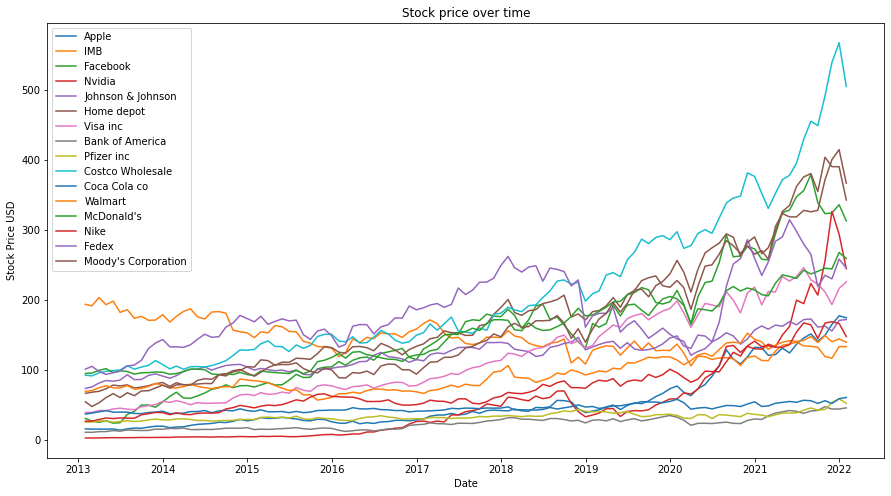

In [6]:
plt.figure(figsize = (15,8))

plt.plot(stocks['AAPL.O'], label="Apple")
plt.plot(stocks['IBM.N'], label="IMB")
plt.plot(stocks['FB.O'], label="Facebook")
plt.plot(stocks['NVDA.O'], label="Nvidia")
plt.plot(stocks['JNJ.N'], label="Johnson & Johnson")
plt.plot(stocks['HD.N'], label="Home depot")
plt.plot(stocks['V.N'], label="Visa inc")
plt.plot(stocks['BAC.N'], label="Bank of America")
plt.plot(stocks['PFE.N'], label="Pfizer inc")
plt.plot(stocks['COST.O'], label="Costco Wholesale")
plt.plot(stocks['KO.N'], label= "Coca Cola co")
plt.plot(stocks['WMT.N'], label="Walmart")
plt.plot(stocks['MCD.N'], label="McDonald's")
plt.plot(stocks['NKE.N'], label="Nike")
plt.plot(stocks['FDX.N'], label="Fedex")
plt.plot(stocks['MCO.N'], label="Moody's Corporation")


plt.title("Stock price over time")
plt.ylabel("Stock Price USD")
plt.xlabel("Date")

plt.legend()
#plt.savefig("Stock prices over time.png")                             
plt.show()


## macro data visualization

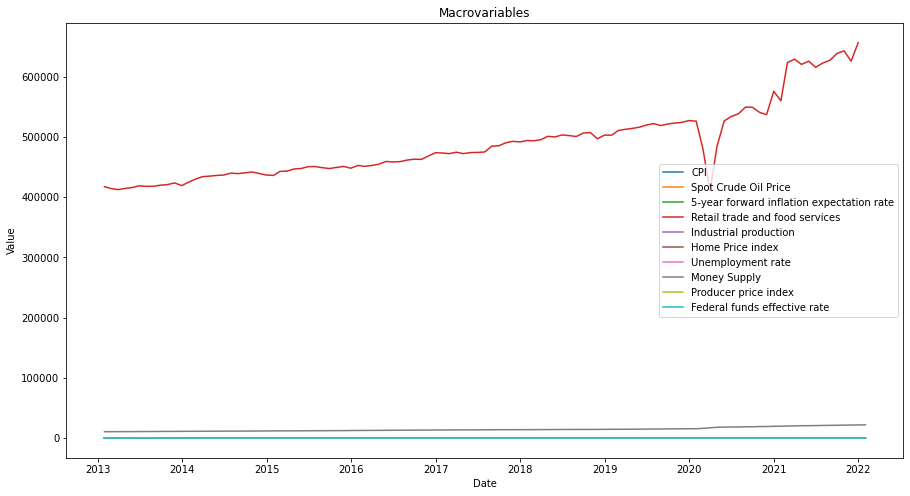

In [7]:
plt.figure(figsize = (15,8))

plt.plot(macro['CPIAUCSL'], label="CPI")
plt.plot(macro['WTISPLC'], label="Spot Crude Oil Price")
plt.plot(macro['T5YIFRM'], label="5-year forward inflation expectation rate")
plt.plot(macro['MRTSSM44X72USS'], label="Retail trade and food services")
plt.plot(macro['INDPRO'], label="Industrial production")
plt.plot(macro['SPCS20RSA'], label="Home Price index")
plt.plot(macro['UNRATE'], label="Unemployment rate")
plt.plot(macro['M2SL'], label="Money Supply")
plt.plot(macro['PPIACO'], label="Producer price index")
plt.plot(macro['FEDFUNDS'], label="Federal funds effective rate")

plt.title("Macrovariables")
plt.ylabel("Value")
plt.xlabel("Date")

plt.legend()
tick_spacing = 20
#plt.savefig("Macro variables over time.png")
plt.show()

#### Sub conclusion
Initial visualization of both the stock and macro data, indicate trends over time and thus non-stationary data.

## Dickey-Fuller test

Check for stationarity

In [8]:
#Dickey-fuller test for the stock dataset
stocks2 = stocks.iloc[:,0].values #Turning the data into a 1-D array, enabling the Dickey-Fuller to function
adfuller(stocks2)

(2.4972008510699837,
 0.9990489423708409,
 13,
 95,
 {'1%': -3.5011373281819504,
  '5%': -2.8924800524857854,
  '10%': -2.5832749307479226},
 589.9224480696482)

In [9]:
#Dickey-fuller test for the macro dataset
macro2 = macro.iloc[:,0].values #Turning the data into a 1-D array, enabling the Dickey-Fuller to function
adfuller(macro2)

(3.446039624692799,
 1.0,
 2,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 141.30187737299923)

#### Sub conclusion
The stock data has a p-value of 0.999 and the macro data has a p-value of 1.0.
As neither has a p-value of less than 0.05, we can say that the data is non-stationary.

## Making data stationary

In [10]:
#Making the stock data stationary
stocks = stocks.pct_change()

In [11]:
#Dropping missing values
stocks = stocks.dropna(how="any")

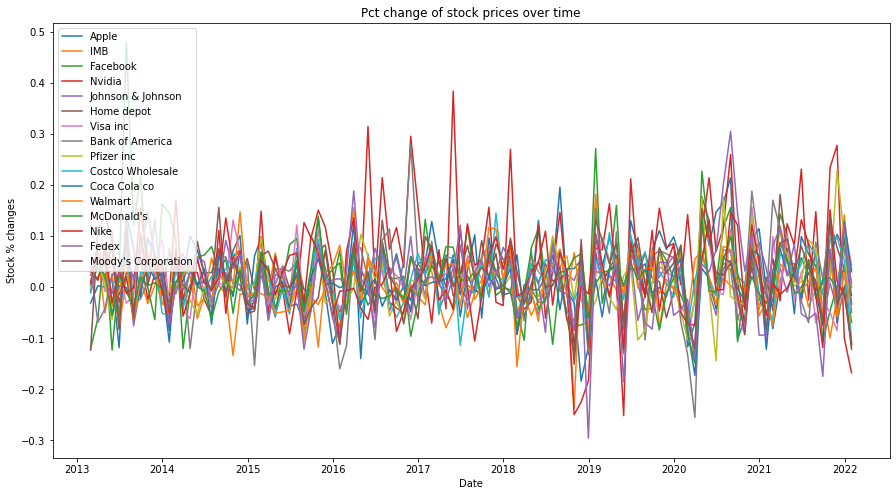

In [12]:
plt.figure(figsize = (15,8))

plt.plot(stocks['AAPL.O'], label="Apple")
plt.plot(stocks['IBM.N'], label="IMB")
plt.plot(stocks['FB.O'], label="Facebook")
plt.plot(stocks['NVDA.O'], label="Nvidia")
plt.plot(stocks['JNJ.N'], label="Johnson & Johnson")
plt.plot(stocks['HD.N'], label="Home depot")
plt.plot(stocks['V.N'], label="Visa inc")
plt.plot(stocks['BAC.N'], label="Bank of America")
plt.plot(stocks['PFE.N'], label="Pfizer inc")
plt.plot(stocks['COST.O'], label="Costco Wholesale")
plt.plot(stocks['KO.N'], label= "Coca Cola co")
plt.plot(stocks['WMT.N'], label="Walmart")
plt.plot(stocks['MCD.N'], label="McDonald's")
plt.plot(stocks['NKE.N'], label="Nike")
plt.plot(stocks['FDX.N'], label="Fedex")
plt.plot(stocks['MCO.N'], label="Moody's Corporation")


plt.title("Pct change of stock prices over time")
plt.ylabel("Stock % changes")
plt.xlabel("Date")

plt.legend()
#plt.savefig("Pct change of stock prices over time.png")                    
plt.show()

In [13]:
#Making macro stationary
macro = macro.pct_change()

In [14]:
#Dropping missing values
macro = macro.dropna(how="any")

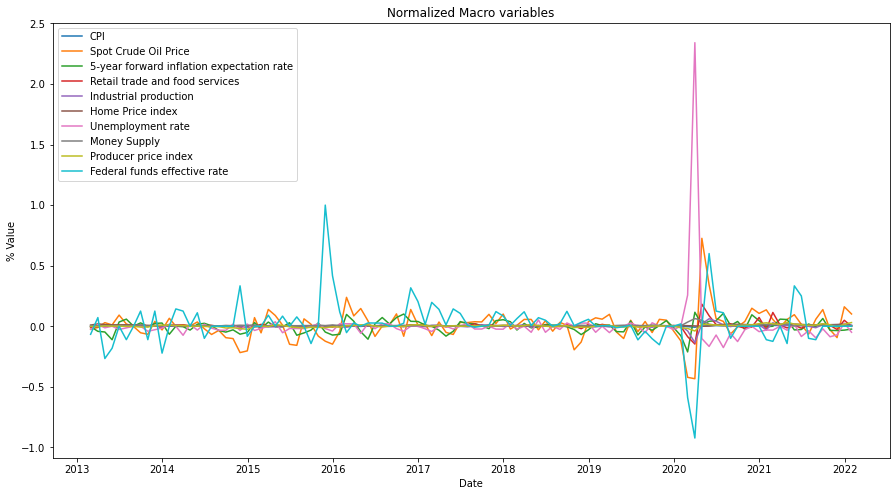

In [15]:
plt.figure(figsize = (15,8))

plt.plot(macro['CPIAUCSL'], label="CPI")
plt.plot(macro['WTISPLC'], label="Spot Crude Oil Price")
plt.plot(macro['T5YIFRM'], label="5-year forward inflation expectation rate")
plt.plot(macro['MRTSSM44X72USS'], label="Retail trade and food services")
plt.plot(macro['INDPRO'], label="Industrial production")
plt.plot(macro['SPCS20RSA'], label="Home Price index")
plt.plot(macro['UNRATE'], label="Unemployment rate")
plt.plot(macro['M2SL'], label="Money Supply")
plt.plot(macro['PPIACO'], label="Producer price index")
plt.plot(macro['FEDFUNDS'], label="Federal funds effective rate")

plt.title("Normalized Macro variables")
plt.ylabel("% Value")
plt.xlabel("Date")
plt.legend()

#plt.savefig("Normalized Macro variables over time.png")
plt.show()

#### Sub conclusion
The data for both stocks and macro now is stationary, however includes outliers such as the unemployment rate which spiked during the early days of COVID

# Multicollinearity

## Merge stocks and macro together

In [16]:
together = stocks.merge(macro, how="outer", on="Date")
together = together.iloc[1:]
together.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,...,CPIAUCSL,WTISPLC,T5YIFRM,MRTSSM44X72USS,INDPRO,SPCS20RSA,UNRATE,M2SL,PPIACO,FEDFUNDS
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-31,0.002855,0.062092,-0.061284,0.013428,0.071213,0.018686,0.070600,0.084595,0.054439,0.047586,...,-0.002088,-0.010532,-0.042105,-0.004480,-0.000676,0.019194,0.013333,0.003413,-0.002451,0.071429
2013-04-30,0.000271,-0.050445,0.085575,0.073266,0.045382,0.051161,-0.008125,0.010673,0.007277,0.021864,...,0.000414,0.029651,-0.047619,0.005026,0.000807,0.013911,-0.013158,0.003987,0.002948,-0.266667
2013-05-31,0.015708,0.027056,-0.123195,0.050835,-0.012320,0.072393,0.057462,0.109667,-0.063295,0.011076,...,0.002380,0.010549,-0.111538,0.003459,0.001352,0.011724,0.000000,0.005346,0.000980,-0.181818
2013-06-30,-0.118303,-0.081290,0.021850,-0.029717,0.019957,-0.015128,0.025879,-0.058565,0.028645,0.008565,...,0.001957,0.091962,0.034632,0.006884,-0.002884,0.011250,-0.026667,0.004297,0.000489,0.000000
2013-07-31,0.141225,0.020564,0.479100,0.028134,0.088982,0.020137,-0.031409,0.135303,0.043556,0.061952,...,0.002387,0.018736,0.058577,-0.002293,0.005855,0.012215,-0.013699,0.005528,-0.000978,-0.111111


In [17]:
#Create a new variable to check for correlation
togc = together.corr()

<AxesSubplot:>

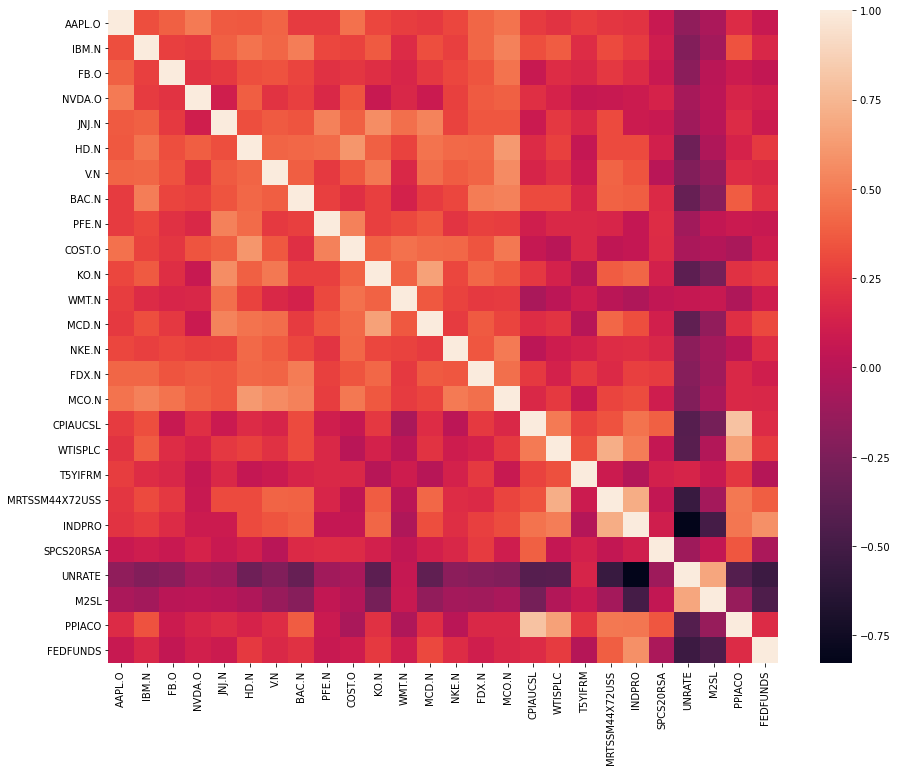

In [18]:
#Visualize the correlation in a seaborn heatmap
plt.figure(figsize=(15,12))

sns.heatmap(togc,
           xticklabels=togc.columns.values,
           yticklabels=togc.columns.values)
#plt.savefig("All stocks and macro heatmap.png")

#### Sub conclusion
We find that there is intercorrelation and thus multicollinearity between some of the dependent variables, such as between industrial production (INDPRO) and Retail trade and food services (MRTSSM44X72USS) as well as between the unemployment rate (UNRATE) and the money supply (M2SL).

# Regression 1
We create subsets of the macro variables in order to run different regressions and see which performs the best.

## Regression of Macro_subset_1

In [19]:
#Creating a subset of the macro data with 3 variables
ms1 = macro[["CPIAUCSL", "T5YIFRM", "PPIACO"]]

In [20]:
#Testing subset for multicollinearity
m1corr = ms1[["CPIAUCSL", "T5YIFRM", "PPIACO"]].corr()
m1corr

,CPIAUCSL,T5YIFRM,PPIACO
CPIAUCSL,1.000000,0.277455,0.797458
T5YIFRM,0.277455,1.000000,0.233957
PPIACO,0.797458,0.233957,1.000000


<AxesSubplot:>

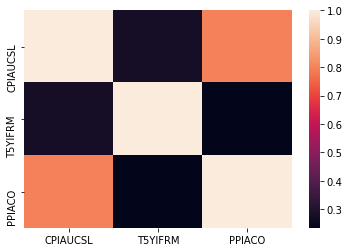

In [21]:
#Visualizing the correlation
sns.heatmap(m1corr, 
            xticklabels=m1corr.columns.values,
            yticklabels=m1corr.columns.values)
#plt.savefig("Macro_subset_1 heatmap.png")

### Actual vs predicted values

In [22]:
#First we create two different dfs and we will subtract one from the other (poi_real - poi_pred)

poi_real = {}
poi_pred = {}
fit_f = {}
for i in stocks: 
        Y= stocks[i]
        X = ms1
        X = sm.add_constant(X)
       
        temp = sm.OLS(Y,X).fit()
        poi_real[i] = Y.values #real values
        poi_pred[i] = temp.predict() #prediction values
        
        
        fit_f[i] = temp

In [24]:
#real values df's creation
pd.DataFrame(poi_real)
poi_dfreal = pd.DataFrame(poi_real)
poi_dfreal.set_index(Y.index, inplace=True)
#poi_dfreal.to_sql('ms1 real_values', engine)
poi_dfreal.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Date,,,,,,,,,,,,,,,,
2013-02-28,-0.030934,-0.011031,-0.120429,0.032626,0.029627,0.023610,0.004623,-0.007951,0.003299,-0.010260,0.039742,0.011866,0.006402,0.007586,0.039231,-0.123313
2013-03-31,0.002855,0.062092,-0.061284,0.013428,0.071213,0.018686,0.070600,0.084595,0.054439,0.047586,0.044421,0.057220,0.039520,0.083548,-0.068576,0.109447
2013-04-30,0.000271,-0.050445,0.085575,0.073266,0.045382,0.051161,-0.008125,0.010673,0.007277,0.021864,0.046736,0.038621,0.024576,0.077783,-0.042668,0.141223
2013-05-31,0.015708,0.027056,-0.123195,0.050835,-0.012320,0.072393,0.057462,0.109667,-0.063295,0.011076,-0.055280,-0.037056,-0.054533,-0.030503,0.024785,0.091865
2013-06-30,-0.118303,-0.081290,0.021850,-0.029717,0.019957,-0.015128,0.025879,-0.058565,0.028645,0.008565,0.003001,-0.004677,0.025163,0.032760,0.023251,-0.082932


In [27]:
#pred values df's creation
pd.DataFrame(poi_pred)
poi_dfpred = pd.DataFrame(poi_pred)
poi_dfpred.set_index(Y.index, inplace=True)
#poi_dfpred.to_sql('ms1 predicted_values', engine)
poi_dfpred.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Date,,,,,,,,,,,,,,,,
2013-02-28,-0.009342,-0.020101,0.021129,0.004745,0.022311,-0.000388,0.016510,0.003706,0.000344,-0.003188,-0.010454,0.017922,0.000240,0.019048,-0.019332,-0.001072
2013-03-31,-0.015346,-0.024252,0.010966,0.011522,0.012787,0.002313,0.013097,-0.001863,-0.005216,-0.004259,-0.005847,0.011186,0.003056,0.011993,-0.026175,0.000983
2013-04-30,-0.000697,-0.010589,0.012906,0.033501,0.009550,0.011839,0.017097,0.013255,-0.002215,0.000186,0.004371,0.005435,0.010716,0.009939,-0.013100,0.012464
2013-05-31,-0.004541,-0.015590,-0.003648,0.052000,-0.009745,0.019269,0.010701,0.003751,-0.010109,0.003106,0.014380,-0.007591,0.016553,-0.001929,-0.019057,0.019037
2013-06-30,0.038303,0.001739,0.034417,0.049155,0.011272,0.018038,0.018095,0.015901,0.015048,0.026163,0.003110,0.011736,0.007715,0.024428,0.024380,0.020210


In [28]:
#subtraction = Calculating Residuals
resms1 = poi_dfreal.subtract(poi_dfpred)
#resms1.to_sql('ms1 residuals', engine)
resms1.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Date,,,,,,,,,,,,,,,,
2013-02-28,-0.021592,0.009070,-0.141557,0.027881,0.007315,0.023998,-0.011887,-0.011657,0.002955,-0.007071,0.050196,-0.006056,0.006162,-0.011462,0.058563,-0.122241
2013-03-31,0.018201,0.086345,-0.072251,0.001906,0.058426,0.016374,0.057503,0.086458,0.059656,0.051845,0.050269,0.046034,0.036465,0.071554,-0.042401,0.108463
2013-04-30,0.000968,-0.039857,0.072669,0.039765,0.035832,0.039322,-0.025222,-0.002582,0.009492,0.021678,0.042364,0.033186,0.013860,0.067844,-0.029568,0.128759
2013-05-31,0.020249,0.042646,-0.119547,-0.001165,-0.002575,0.053123,0.046760,0.105916,-0.053186,0.007970,-0.069660,-0.029465,-0.071086,-0.028574,0.043842,0.072828
2013-06-30,-0.156606,-0.083029,-0.012568,-0.078871,0.008685,-0.033166,0.007783,-0.074466,0.013596,-0.017598,-0.000109,-0.016413,0.017449,0.008332,-0.001129,-0.103142


In [29]:
# quality check
-0.030934 - (-0.009342) 

-0.021592

### P-values and R-Squared of the ms1 regression

In [30]:
#Run a regression for stocks and macro_subset_1
jio = {} 
for stock in stocks:
    Y = stocks[stock]
    X = ms1
    X = sm.add_constant(X)
    
    regre1 = sm.OLS(Y,X).fit()
    Lregre1 = (regre1.pvalues)
    jio[stock] = Lregre1

In [31]:
#Save the regression P-value results to a dataframe
jiooo = pd.DataFrame(jio)
jiooo.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
const,0.205499,0.245147,0.047497,0.042117,0.021703,0.174278,0.025827,0.326818,0.480784,0.115714,0.858120,0.076074,0.325597,0.028357,0.975394,0.205178
CPIAUCSL,0.094050,0.414443,0.924641,0.175495,0.142504,0.274467,0.881137,0.869403,0.646216,0.075623,0.249255,0.440942,0.515552,0.943350,0.156301,0.296592
T5YIFRM,0.038748,0.277792,0.150066,0.976180,0.124661,0.981645,0.640136,0.538490,0.145302,0.093650,0.470730,0.213899,0.550157,0.163552,0.046791,0.874704
PPIACO,0.630101,0.157394,0.775106,0.875639,0.037205,0.984538,0.217220,0.026168,0.959085,0.041396,0.639120,0.828851,0.413780,0.942108,0.722709,0.843306


In [32]:
#Run a regression for stocks and macro_subset_1
pio = {} 
for stock in stocks:
    Y = stocks[stock]
    X = ms1
    X = sm.add_constant(X)
    
    regre1 = sm.OLS(Y,X).fit()
    Lregre1 = (regre1.rsquared)
    pio[stock] = Lregre1
    pio[stock] = {}
    pio[stock]["R-squared"] = Lregre1

In [33]:
#Save the regression R-squared results to a dataframe
piooo = pd.DataFrame(pio).T
piooo.head()

,R-squared
AAPL.O,0.106678
IBM.N,0.133699
FB.O,0.029116
NVDA.O,0.040517
JNJ.N,0.067870


### Checking the residuals of stocks, checking for normality as well as testing for heteroskedasticity and autocorrelation

In [34]:
#Normality of the residuals 
test1 = {}
name1 = ['Jarque-Bera', 'JB P-value', 'Skew', 'Kurtosis']
for i in resms1:
    R1 = resms1[i]
    test1[i] = sms.jarque_bera(R1)

In [35]:
#df creation for the jarque-bera test
pd.DataFrame(test1)
name1 = ['Jarque-Bera', 'JB P-value', 'Skew', 'Kurtosis']
resms1_test = pd.DataFrame(test1, index=name1)
#resms1_test.to_sql('ms1 jarque_bera', engine)
resms1_test.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Jarque-Bera,0.602453,4.727024,1.209757e+02,3.492317,0.436943,3.682245,0.135889,0.296942,17.824602,2.573277,8.438362,2.383246,2.378238,0.387008,4.291396e+01,1.871671
JB P-value,0.739910,0.094089,5.376145e-27,0.174443,0.803746,0.158639,0.934312,0.862025,0.000135,0.276198,0.014711,0.303728,0.304489,0.824067,4.801231e-10,0.392258
Skew,-0.127292,0.076382,1.244532e+00,0.112859,-0.137271,0.083109,-0.077133,0.123999,0.600034,-0.376859,-0.641979,-0.114005,0.229883,0.057615,-3.254243e-01,-0.252270
Kurtosis,2.737197,4.013466,7.548411e+00,3.851541,2.852604,3.889184,2.920002,2.933036,4.587721,2.938770,3.476071,3.691102,3.563128,2.730327,6.018747e+00,2.598295


In [36]:
# Breusch Pagan Test for Heteroskedastic residuals

hetero1 = {}

for i in fit_f:
    hetero1[i] = sms.het_breuschpagan(fit_f[i].resid, fit_f[i].model.exog)

In [39]:
#df creation for B-P test
name1 = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
pd.DataFrame(hetero1)
het1 = pd.DataFrame(hetero1, index=name1)
#het1.to_sql('Bresuch_Pagan_test', engine)
het1.head()




,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Lagrange multiplier statistic,1.425633,0.745730,4.081426,5.805018,1.482467,2.277757,0.575011,7.285133,6.460745,1.211031,0.451398,1.436322,5.388624,3.425941,1.161587,3.305533
p-value,0.699537,0.862399,0.252805,0.121492,0.686323,0.516796,0.902128,0.063344,0.091224,0.750360,0.929432,0.697043,0.145454,0.330495,0.762231,0.346873
f-value,0.463732,0.241035,1.361541,1.969183,0.482476,0.746884,0.185559,2.507587,2.205772,0.393134,0.145501,0.467256,1.820516,1.135712,0.376909,1.094536
f p-value,0.708213,0.867533,0.258716,0.123179,0.695179,0.526561,0.906010,0.062990,0.091821,0.758195,0.932354,0.705754,0.147996,0.338219,0.769836,0.354907


In [40]:
#Durbin Watson Test
dw_pvalues1 = {}
for i in resms1:
    D1 = resms1[i]
    dw_pvalues1[i]= sm.stats.stattools.durbin_watson(D1)
    #print("\n","Durbin Watson Test Statistics", dw_pvalues1)

In [41]:
dw1 =  pd.DataFrame(dw_pvalues1, index= ['AAPL.O', 'IBM.N', 
                                 'FB.O', 'NVDA.O', 'JNJ.N', 'HD.N', 'V.N', 
                                 'BAC.N', 'PFE.N', 'COST.O', 'KO.N', 'WMT.N', 
                                 'MCD.N', 'NKE.N', 'FDX.N', 'MCO.N'])
dw_test1 = dw1[:1]
dw_test1.rename(index={'AAPL.O': 'DW'}, inplace=True)
#dw_test1.to_sql('Durbin_Watson', engine)
dw_test1

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
DW,2.060351,2.528755,1.943319,1.944981,2.179196,2.146328,2.254696,2.283357,2.091013,2.044824,2.396502,2.152638,2.007248,2.011906,1.934143,2.213977


#### Sub conclusion - Regressions ms1 - Focus on the Apple Stock

The Jarque-Bera test and p value at 0.60 and 0.73, indicate that the residuals are somewhat normally distributed.
The test for skew and kurtosis, further shows that the residuals are close to being normally distributed, but have
that it is slightly left skewed while also having lighter tails than a fully normal distribution.


The Breusch pagan test shows a langrange multiplier statistic of 1.42 with a p-value of 0.69,
indicating that heteroskedasticity is not present.



The Durbin Watson test result is 2.06, indicating no autocorrelation

# Regression 2

## Regression of Macro_subset_2

In [42]:
#Creating a subset of the macro data with 4 variables
ms2 = macro[["INDPRO", "T5YIFRM", "SPCS20RSA","UNRATE"]]

In [43]:
#Testing subset for multicollinearity
m2corr = ms2[["INDPRO", "T5YIFRM", "SPCS20RSA","UNRATE"]].corr()
m2corr

,INDPRO,T5YIFRM,SPCS20RSA,UNRATE
INDPRO,1.000000,-0.017154,0.115926,-0.826836
T5YIFRM,-0.017154,1.000000,0.127728,0.148015
SPCS20RSA,0.115926,0.127728,1.000000,-0.110293
UNRATE,-0.826836,0.148015,-0.110293,1.000000


<AxesSubplot:>

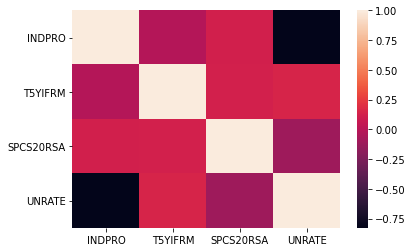

In [44]:
#Visualizing the correlation
sns.heatmap(m2corr, 
            xticklabels=m2corr.columns.values,
            yticklabels=m2corr.columns.values)
#plt.savefig("Macro_subset_2 heatmap.png")

### Actual vs predicted values

In [45]:
#First we create two different dfs and we will subtract one from the other (loi_real - loi_pred)

loi_real = {}
loi_pred = {}
fit_g = {}
for i in stocks: 
        Y= stocks[i]
        X = ms2
        X = sm.add_constant(X)
       
        temp = sm.OLS(Y,X).fit()
        loi_real[i] = Y.values #real values
        loi_pred[i] = temp.predict() #prediction values
        
        
        fit_g[i] = temp


In [46]:
#real values df's creation
pd.DataFrame(loi_real)
loi_dfreal = pd.DataFrame(loi_real)
loi_dfreal.set_index(Y.index, inplace=True)
#loi_dfreal.to_sql('ms2 real_values', engine)
loi_dfreal.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Date,,,,,,,,,,,,,,,,
2013-02-28,-0.030934,-0.011031,-0.120429,0.032626,0.029627,0.023610,0.004623,-0.007951,0.003299,-0.010260,0.039742,0.011866,0.006402,0.007586,0.039231,-0.123313
2013-03-31,0.002855,0.062092,-0.061284,0.013428,0.071213,0.018686,0.070600,0.084595,0.054439,0.047586,0.044421,0.057220,0.039520,0.083548,-0.068576,0.109447
2013-04-30,0.000271,-0.050445,0.085575,0.073266,0.045382,0.051161,-0.008125,0.010673,0.007277,0.021864,0.046736,0.038621,0.024576,0.077783,-0.042668,0.141223
2013-05-31,0.015708,0.027056,-0.123195,0.050835,-0.012320,0.072393,0.057462,0.109667,-0.063295,0.011076,-0.055280,-0.037056,-0.054533,-0.030503,0.024785,0.091865
2013-06-30,-0.118303,-0.081290,0.021850,-0.029717,0.019957,-0.015128,0.025879,-0.058565,0.028645,0.008565,0.003001,-0.004677,0.025163,0.032760,0.023251,-0.082932


In [47]:
#pred values df's creation
pd.DataFrame(loi_pred)
loi_dfpred = pd.DataFrame(loi_pred)
loi_dfpred.set_index(Y.index, inplace=True)
#loi_dfpred.to_sql('ms2 predicted_values', engine)
loi_dfpred.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Date,,,,,,,,,,,,,,,,
2013-02-28,0.028258,0.003016,0.028629,0.058299,0.010272,0.023171,0.020377,0.027432,0.014126,0.021971,0.011698,0.008434,0.014630,0.024595,0.025411,0.025658
2013-03-31,0.008701,-0.005041,0.015447,0.080679,0.006989,0.023740,0.005181,0.028017,0.025820,0.030942,0.013974,0.009431,0.016547,0.030173,0.038578,0.023418
2013-04-30,0.007495,-0.007934,0.013921,0.065484,0.004755,0.020931,0.009067,0.020029,0.014893,0.022020,0.011732,0.006554,0.014791,0.022329,0.020739,0.020882
2013-05-31,-0.019509,-0.026111,-0.009426,0.053075,-0.007226,0.013481,0.005663,-0.000358,-0.004122,0.007612,0.009010,0.000266,0.009967,0.007623,-0.010185,0.015240
2013-06-30,0.039313,0.010481,0.041479,0.063877,0.018448,0.024356,0.012131,0.032583,0.029842,0.032146,0.008718,0.012483,0.017013,0.031538,0.039192,0.020329


In [48]:
#subtraction = Calculating residuals
resms2 = loi_dfreal.subtract(loi_dfpred)
resms2.to_sql('ms2 residuals', engine)
resms2.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Date,,,,,,,,,,,,,,,,
2013-02-28,-0.059192,-0.014047,-0.149058,-0.025672,0.019354,0.000439,-0.015754,-0.035383,-0.010827,-0.032231,0.028044,0.003431,-0.008228,-0.017009,0.013820,-0.148971
2013-03-31,-0.005847,0.067133,-0.076731,-0.067251,0.064224,-0.005054,0.065419,0.056578,0.028619,0.016644,0.030448,0.047788,0.022973,0.053374,-0.107154,0.086029
2013-04-30,-0.007224,-0.042512,0.071654,0.007782,0.040627,0.030230,-0.017193,-0.009356,-0.007617,-0.000156,0.035004,0.032067,0.009786,0.055454,-0.063407,0.120341
2013-05-31,0.035216,0.053167,-0.113769,-0.002240,-0.005094,0.058912,0.051799,0.110025,-0.059173,0.003464,-0.064290,-0.037322,-0.064500,-0.038126,0.034970,0.076626
2013-06-30,-0.157616,-0.091772,-0.019629,-0.093594,0.001509,-0.039484,0.013748,-0.091148,-0.001197,-0.023581,-0.005718,-0.017159,0.008150,0.001222,-0.015941,-0.103261


### P-values and R-Squared of the ms2 regression

In [49]:
#Run a regression for stocks and macro_subset_2
kio = {} 
for stock in stocks:
    Y = stocks[stock]
    X = ms2
    X = sm.add_constant(X)
    
    regre2 = sm.OLS(Y,X).fit()
    Lregre2 = (regre2.pvalues)
    kio[stock] = Lregre2

In [50]:
#Save the regression P-value results to a dataframe
kiooo = pd.DataFrame(kio).T
kiooo.head()

,const,INDPRO,T5YIFRM,SPCS20RSA,UNRATE
AAPL.O,0.040552,0.342167,0.005996,0.937805,0.665508
IBM.N,0.624403,0.416370,0.036304,0.631945,0.432697
FB.O,0.094492,0.904783,0.060163,0.849908,0.266003
NVDA.O,0.114843,0.652637,0.666171,0.214212,0.999290
JNJ.N,0.328453,0.736994,0.067151,0.681818,0.316518


In [51]:
#Run a regression for stocks and macro_subset_2
mio = {} 
for stock in stocks:
    Y = stocks[stock]
    X = ms2
    X = sm.add_constant(X)
    
    regre2_2 = sm.OLS(Y,X).fit()
    Lregre2_2 = (regre2_2.rsquared)
    mio[stock] = Lregre2_2
    mio[stock] = {}
    mio[stock]["R-squared"] = Lregre2_2

In [52]:
#Save the regression R-squared results to a dataframe
miooo = pd.DataFrame(mio).T
miooo.head()

,R-squared
AAPL.O,0.117101
IBM.N,0.107836
FB.O,0.071352
NVDA.O,0.027054
JNJ.N,0.047188


### Checking the residuals of stocks, checking for normality as well as testing for heteroskedasticity and autocorrelation

In [53]:

#Normality of the residuals 
test2 = {}
name2 = ['Jarque-Bera', 'JB P-value', 'Skew', 'Kurtosis']
for i in resms2:
    R2 = resms2[i]
    test2[i] = sms.jarque_bera(R2)

In [54]:
#df creation for the jarque-bera test
pd.DataFrame(test2)
name2 = ['Jarque-Bera', 'JB P-value', 'Skew', 'Kurtosis']
resms2_test = pd.DataFrame(test2, index=name2)
#resms2_test.to_sql('ms2 jarque_bera', engine)
resms2_test.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Jarque-Bera,1.509501,10.696855,1.230949e+02,3.060080,0.253020,2.998695,1.359284,0.263878,13.937108,2.653949,3.175686,2.254544,5.135328,0.485800,3.931613e+01,2.193429
JB P-value,0.470128,0.004756,1.863255e-27,0.216527,0.881165,0.223276,0.506798,0.876394,0.000941,0.265279,0.204366,0.323916,0.076715,0.784350,2.901429e-09,0.333967
Skew,-0.241972,0.037942,1.264414e+00,0.251160,-0.026413,0.093445,0.107078,0.073199,0.609610,-0.383021,-0.414595,-0.074686,0.484337,-0.019910,-4.340649e-01,-0.271470
Kurtosis,2.681812,4.539909,7.578151e+00,3.653981,3.231162,3.794637,2.493838,3.192892,4.269108,2.945736,2.865268,3.691880,3.450396,2.673856,5.825468e+00,2.561088


In [55]:
# Breusch Pagan Test for Heteroskedastic residuals

hetero2 = {}

for i in fit_g:
    hetero2[i] = sms.het_breuschpagan(fit_g[i].resid, fit_g[i].model.exog)

In [56]:
#df creation for B-P test
name2 = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
pd.DataFrame(hetero2)
het2 = pd.DataFrame(hetero2, index=name2)
#het2.to_sql('ms2 Bresuch_Pagan_test', engine)
het2.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Lagrange multiplier statistic,2.471586,1.723949,3.347918,5.009045,4.322637,3.344057,9.107991,2.382073,3.607980,3.752832,7.414085,1.170820,2.577038,2.629282,2.516950,0.962595
p-value,0.649731,0.786363,0.501376,0.286371,0.364099,0.501982,0.058456,0.665869,0.461651,0.440489,0.115558,0.882879,0.630896,0.621645,0.641603,0.915414
f-value,0.603092,0.417702,0.823767,1.252371,1.073599,0.822786,2.371585,0.580757,0.889967,0.926984,1.898006,0.282213,0.629452,0.642532,0.614425,0.231572
f p-value,0.661264,0.795545,0.512949,0.293661,0.373508,0.513560,0.057184,0.677244,0.472810,0.451356,0.116401,0.888913,0.642575,0.633380,0.653204,0.920065


In [57]:
#Durbin Watson Test
dw_pvalues2 = {}
for i in resms2:
    D2 = resms2[i]
    dw_pvalues2[i]= sm.stats.stattools.durbin_watson(D2)
    #print("\n","ms2 Durbin Watson Test Statistics", dw_pvalues2)

In [58]:
dw2 =  pd.DataFrame(dw_pvalues2, index= ['AAPL.O', 'IBM.N', 
                                 'FB.O', 'NVDA.O', 'JNJ.N', 'HD.N', 'V.N', 
                                 'BAC.N', 'PFE.N', 'COST.O', 'KO.N', 'WMT.N', 
                                 'MCD.N', 'NKE.N', 'FDX.N', 'MCO.N'])
dw_test2 = dw2[:1]
dw_test2.rename(index={'AAPL.O': 'DW2'}, inplace=True)
#dw_test2.to_sql('ms2 Durbin_Watson', engine)
dw_test2

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
DW2,2.135656,2.449862,1.890556,2.005373,2.106322,2.138137,2.289961,2.346348,2.026614,2.008395,2.519955,2.119239,2.020761,2.052538,2.038142,2.189396


#### Sub conclusion

The Jarque-Bera test and p value at 1.48 and 0.47, indicate that the residuals are somewhat normally distributed.
The test for skew and kurtosis, further shows that the residuals are close to being normally distributed, but have
that it is slightly left skewed while also having lighter tails than a fully normal distribution.


The Breusch pagan test shows a langrange multiplier statistic of 2.25 with a p-value of 0.68,
indicating that heteroskedasticity is not present.



The Durbin Watson test result is 2.13, indicating no autocorrelation

# Regression 3

## Regression of Macro_subset_3

In [59]:
ms3 = macro[["CPIAUCSL", "FEDFUNDS", "MRTSSM44X72USS","UNRATE","WTISPLC"]]

In [60]:
m3corr = ms3[["CPIAUCSL", "FEDFUNDS", "MRTSSM44X72USS","UNRATE","WTISPLC"]].corr()
m3corr

,CPIAUCSL,FEDFUNDS,MRTSSM44X72USS,UNRATE,WTISPLC
CPIAUCSL,1.000000,0.190503,0.340161,-0.405948,0.485214
FEDFUNDS,0.190503,1.000000,0.384774,-0.538471,0.256902
MRTSSM44X72USS,0.340161,0.384774,1.000000,-0.553010,0.714445
UNRATE,-0.405948,-0.538471,-0.553010,1.000000,-0.405577
WTISPLC,0.485214,0.256902,0.714445,-0.405577,1.000000


<AxesSubplot:>

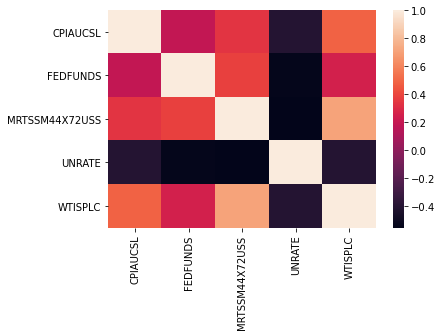

In [61]:
sns.heatmap(m3corr,
           xticklabels=m3corr.columns.values,
           yticklabels=m3corr.columns.values)
#plt.savefig("Macro_subset_3 heatmap.png")

In [62]:
#First we create two different dfs and we will subtract one from the other (hoi_real - hoi_pred)

hoi_real = {}
hoi_pred = {}
fit_k = {}
for i in stocks: 
        Y= stocks[i]
        X = ms3
        X = sm.add_constant(X)
       
        temp = sm.OLS(Y,X).fit()
        hoi_real[i] = Y.values #real values
        hoi_pred[i] = temp.predict() #prediction values
        
        
        fit_k[i] = temp

In [63]:
#real values df's creation
pd.DataFrame(hoi_real)
hoi_dfreal = pd.DataFrame(hoi_real)
hoi_dfreal.set_index(Y.index, inplace=True)
#hoi_dfreal.to_sql('ms3 real_values', engine)
hoi_dfreal.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Date,,,,,,,,,,,,,,,,
2013-02-28,-0.030934,-0.011031,-0.120429,0.032626,0.029627,0.023610,0.004623,-0.007951,0.003299,-0.010260,0.039742,0.011866,0.006402,0.007586,0.039231,-0.123313
2013-03-31,0.002855,0.062092,-0.061284,0.013428,0.071213,0.018686,0.070600,0.084595,0.054439,0.047586,0.044421,0.057220,0.039520,0.083548,-0.068576,0.109447
2013-04-30,0.000271,-0.050445,0.085575,0.073266,0.045382,0.051161,-0.008125,0.010673,0.007277,0.021864,0.046736,0.038621,0.024576,0.077783,-0.042668,0.141223
2013-05-31,0.015708,0.027056,-0.123195,0.050835,-0.012320,0.072393,0.057462,0.109667,-0.063295,0.011076,-0.055280,-0.037056,-0.054533,-0.030503,0.024785,0.091865
2013-06-30,-0.118303,-0.081290,0.021850,-0.029717,0.019957,-0.015128,0.025879,-0.058565,0.028645,0.008565,0.003001,-0.004677,0.025163,0.032760,0.023251,-0.082932


In [64]:
#pred values df's creation
pd.DataFrame(hoi_pred)
hoi_dfpred = pd.DataFrame(hoi_pred)
hoi_dfpred.set_index(Y.index, inplace=True)
#hoi_dfpred.to_sql('ms3 predicted_values', engine)
hoi_dfpred.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Date,,,,,,,,,,,,,,,,
2013-02-28,-0.006342,-0.029127,0.026928,0.004365,0.004533,0.010929,0.002261,-0.016988,0.001083,0.006961,-0.010111,0.007290,-0.001681,0.018913,-0.016253,0.002511
2013-03-31,-0.002908,-0.021629,0.020294,0.022182,0.006567,0.014837,0.005536,-0.012230,0.003231,0.011722,-0.009119,0.014699,0.002287,0.022895,-0.013836,0.006971
2013-04-30,0.021506,-0.009956,0.041157,0.015420,0.009788,0.010685,0.013380,0.008036,0.007371,0.006398,-0.001090,-0.004477,0.000836,0.009024,0.003737,0.013097
2013-05-31,0.030945,-0.002153,0.033640,0.036400,0.007765,0.011847,0.016351,0.017766,0.008062,0.012499,0.005397,-0.002885,0.005191,0.008887,0.015009,0.017313
2013-06-30,0.027791,0.008539,0.031480,0.052403,0.011257,0.022255,0.013149,0.017876,0.012758,0.014013,-0.002194,0.007515,0.006322,0.016092,0.009749,0.022368


In [65]:
#subtraction = Calculating residuals
resms3 = hoi_dfreal.subtract(hoi_dfpred)
#resms3.to_sql('ms3 residuals', engine)
resms3.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Date,,,,,,,,,,,,,,,,
2013-02-28,-0.024591,0.018096,-0.147357,0.028261,0.025094,0.012681,0.002362,0.009038,0.002216,-0.017221,0.049853,0.004575,0.008082,-0.011328,0.055485,-0.125823
2013-03-31,0.005763,0.083722,-0.081579,-0.008754,0.064645,0.003849,0.065064,0.096825,0.051208,0.035864,0.053541,0.042520,0.037233,0.060653,-0.054741,0.102475
2013-04-30,-0.021235,-0.040490,0.044418,0.057845,0.035594,0.040475,-0.021505,0.002637,-0.000095,0.015466,0.047826,0.043097,0.023741,0.068759,-0.046405,0.128126
2013-05-31,-0.015238,0.029210,-0.156835,0.014435,-0.020084,0.060546,0.041111,0.091901,-0.071357,-0.001423,-0.060677,-0.034171,-0.059724,-0.039391,0.009775,0.074552
2013-06-30,-0.146094,-0.089829,-0.009630,-0.082119,0.008700,-0.037384,0.012730,-0.076441,0.015887,-0.005448,0.005195,-0.012192,0.018842,0.016669,0.013502,-0.105300


### P-values and R-Squared of the ms3 regression

In [66]:
#Run a regression for stocks and macro_subset_3
nio = {} 
for stock in stocks:
    Y = stocks[stock]
    X = ms3
    X = sm.add_constant(X)
    
    regre3 = sm.OLS(Y,X).fit()
    Lregre3 = (regre3.pvalues)
    nio[stock] = Lregre3

In [67]:
#Save the regression P-value results to a dataframe
niooo = pd.DataFrame(nio).T
niooo.head()

,const,CPIAUCSL,FEDFUNDS,MRTSSM44X72USS,UNRATE,WTISPLC
AAPL.O,0.200101,0.078114,0.745135,0.259313,0.960530,0.941839
IBM.N,0.129737,0.085845,0.660258,0.624568,0.938491,0.105738
FB.O,0.029861,0.829688,0.419755,0.213521,0.348345,0.785911
NVDA.O,0.028747,0.117230,0.269584,0.606604,0.619376,0.505353
JNJ.N,0.186867,0.761168,0.969638,0.036257,0.518754,0.655919


In [68]:
#Run a regression for stocks and macro_subset_3
bio = {} 
for stock in stocks:
    Y = stocks[stock]
    X = ms3
    X = sm.add_constant(X)
    
    regre3_3 = sm.OLS(Y,X).fit()
    Lregre3_3 = (regre3_3.rsquared)
    bio[stock] = Lregre3_3
    bio[stock] = {}
    bio[stock]["R-squared"] = Lregre3_3

In [69]:
#Save the regression R-squared results to a dataframe
biooo = pd.DataFrame(mio).T
biooo.head()

,R-squared
AAPL.O,0.117101
IBM.N,0.107836
FB.O,0.071352
NVDA.O,0.027054
JNJ.N,0.047188


### Checking the residuals of 1 stock, checking for normality as well as testing for heteroskedasticity and autocorrelation

In [70]:
#Normality of the residuals 
test3 = {}
name3 = ['Jarque-Bera', 'JB P-value', 'Skew', 'Kurtosis']
for i in resms3:
    R3 = resms3[i]
    test3[i] = sms.jarque_bera(R3)

In [71]:
#df creation for the jarque-bera test
pd.DataFrame(test3)
name3 = ['Jarque-Bera', 'JB P-value', 'Skew', 'Kurtosis']
resms3_test = pd.DataFrame(test3, index=name3)
#resms3_test.to_sql('ms3 jarque_bera', engine)
resms3_test.head()

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Jarque-Bera,1.463040,3.401581,1.790770e+02,3.166159,3.034036,2.567178,0.831705,3.441992,16.764055,2.519439,2.126907,2.413766,0.930112,0.370134,3.541255e+01,2.273405
JB P-value,0.481177,0.182539,1.299918e-39,0.205342,0.219365,0.277041,0.659777,0.178888,0.000229,0.283734,0.345261,0.299128,0.628100,0.831049,2.042975e-08,0.320875
Skew,-0.284956,-0.008951,1.416250e+00,0.136718,-0.407435,-0.023169,0.214442,0.213604,0.542550,-0.373989,-0.343347,-0.143729,0.215311,0.082016,-2.619953e-01,-0.280478
Kurtosis,2.982114,3.869245,8.636651e+00,3.792984,3.101084,3.753881,3.029701,3.763139,4.596216,2.979931,2.966864,3.673617,3.145798,2.764744,5.755883e+00,2.563504


In [72]:
# Breusch Pagan Test for Heteroskedastic residuals

hetero3 = {}

for i in fit_k:
    hetero3[i] = sms.het_breuschpagan(fit_k[i].resid, fit_k[i].model.exog)

In [73]:
#df creation for B-P test
name3 = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
pd.DataFrame(hetero3)
het3 = pd.DataFrame(hetero3, index=name3)
#het3.to_sql('ms3 Bresuch_Pagan_test', engine)
het3.head()


,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
Lagrange multiplier statistic,4.068765,0.981412,1.645774,3.966243,3.524054,8.318431,4.247391,6.434940,7.585092,1.753124,5.647208,1.772070,14.065454,5.285169,1.581490,2.556700
p-value,0.539559,0.964051,0.895659,0.554286,0.619751,0.139537,0.514375,0.266167,0.180633,0.882140,0.342074,0.879698,0.015199,0.382078,0.903479,0.767933
f-value,0.798632,0.187078,0.315679,0.777741,0.688108,1.702381,0.835129,1.292499,1.540965,0.336610,1.125549,0.340308,3.054630,1.049678,0.303165,0.494642
f p-value,0.553155,0.966899,0.902555,0.567982,0.633529,0.140755,0.527735,0.272998,0.183752,0.889694,0.351658,0.887366,0.013054,0.392860,0.909974,0.779600


In [74]:
#Durbin Watson Test
dw_pvalues3 = {}
for i in resms3:
    D3 = resms3[i]
    dw_pvalues3[i]= sm.stats.stattools.durbin_watson(D3)
    #print("\n","ms3 Durbin Watson Test Statistics", dw_pvalues3)

In [75]:
dw3 =  pd.DataFrame(dw_pvalues3, index= ['AAPL.O', 'IBM.N', 
                                 'FB.O', 'NVDA.O', 'JNJ.N', 'HD.N', 'V.N', 
                                 'BAC.N', 'PFE.N', 'COST.O', 'KO.N', 'WMT.N', 
                                 'MCD.N', 'NKE.N', 'FDX.N', 'MCO.N'])
dw_test3 = dw3[:1]
dw_test3.rename(index={'AAPL.O': 'DW3'}, inplace=True)
#dw_test3.to_sql('ms3 Durbin_Watson', engine)
dw_test3

,AAPL.O,IBM.N,FB.O,NVDA.O,JNJ.N,HD.N,V.N,BAC.N,PFE.N,COST.O,KO.N,WMT.N,MCD.N,NKE.N,FDX.N,MCO.N
DW3,1.967922,2.538865,1.865153,1.982913,2.213924,2.170052,2.26242,2.249402,2.097745,2.039154,2.405754,2.11535,2.072543,2.02078,1.781286,2.21696


#### Sub conclusion

The Jarque-Bera test and p value at 1.65 and 0.43, indicate that the residuals are somewhat normally distributed.
The test for skew and kurtosis, further shows that the residuals are close to being normally distributed, but have
that it is slightly left skewed while also having lighter tails than a fully normal distribution.


The Breusch pagan test shows a langrange multiplier statistic of 3.56 with a p-value of 0.61,
indicating that heteroskedasticity is not present.



The Durbin Watson test result is 2.04, indicating no autocorrelation

# Uploading clean data and results to SQL

In [76]:
#To be uploaded to the SQL database: 10000_reg

# Step 1:
#1. Stock data
##stocks.to_sql('stocks_values', engine)

#2. Macro data
##macro.to_sql('macro_values', engine)

#Step 2:

#3. Stock.pct_change data
##stocks.to_sql('stocks_pct', engine)

#4. macro.pct_change data
##macro.to_sql('macro_pct', engine)

#5. Stock.describe
##stock_des.to_sql('stock_description', engine)

#6. macro.describe
##macro_des.to_sql('macro_description', engine)

#7. Real + predic values ms1 - poi_df
##poi_df.to_sql('ms1 real and predicted values', engine)

#8. Real + predic values ms2 - loi_df
##loi_df.to_sql('ms2 real and predicted values', engine)

#9. Real + predic values ms3 - hoi_df
#hoi_df.to_sql('ms3 real and predicted values', engine)

#10. p-value ms1 - jiooo
#jiooo.to_sql('ms1 p-values', engine)

#11. r-squared ms1 - piooo
#piooo.to_sql('ms1 r-squared', engine)

#12. p-value ms2 - kiooo
#kiooo.to_sql('ms2 p-values', engine)

#13. r-squared ms2 - miooo
#miooo.to_sql('ms2 r-squared', engine)

#14. p-value ms3 - niooo
#niooo.to_sql('ms3 p-values', engine)

#15. r-squared ms3 - biooo
#biooo.to_sql('ms3 r-squared', engine)

#----------------------------------------# Davide's addition

#16.
#poi_dfreal.to_sql('ms1 real_values', engine)

#17.
#poi_dfpred.to_sql('ms1 predicted_values', engine)

#18.
#resms1.to_sql('ms1 residuals', engine)

#19.
#resms1_test.to_sql('ms1 jarque_bera', engine)

#20.
#het1.to_sql('ms1 Bresuch_Pagan_test', engine)

#21.
#dw_test1.to_sql('ms1 Durbin_Watson', engine)


#---------------------------------------# Additional from Nicolai

#22.
#loi_dfreal.to_sql('ms2 real_values', engine)

#23.
#loi_dfpred.to_sql('ms2 predicted_values', engine)

#24.
#resms2.to_sql('ms2 residuals', engine)

#25.
#resms2_test.to_sql('ms2 jarque_bera', engine)

#26.
#het2.to_sql('ms2 Bresuch_Pagan_test', engine)

#27.
#dw_test2.to_sql('ms2 Durbin_Watson', engine)


#28.
#hoi_dfreal.to_sql('ms3 real_values', engine)

#29. 
#hoi_dfpred.to_sql('ms3 predicted_values', engine)

#30.
#resms3.to_sql('ms3 residuals', engine)

#31.
#resms3_test.to_sql('ms3 jarque_bera', engine)

#32.
#het3.to_sql('ms3 Bresuch_Pagan_test', engine)

#33. 
#dw_test3.to_sql('ms3 Durbin_Watson', engine)